In [29]:
import numpy as np
import pandas as pd
import json

import networkx as nx

import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
households = pd.read_csv("../ml-python/data/processed/households_processed.csv")

In [31]:
edges = pd.read_csv("../ml-python/data/processed/edges_processed.csv")

In [32]:
with open("../ml-python/data/processed/flood_scenario_processed.json") as f:
    flood = json.load(f)

In [33]:
print("Households:", households.shape)
print("Edges:", edges.shape)
print("Flood affected households:", len(flood['affected_households']))

Households: (1000, 17)
Edges: (2495, 7)
Flood affected households: 100


In [34]:
G = nx.Graph()

In [35]:
for _, row in households.iterrows():
    G.add_node(
    row['id'],
    need_score=row['need_score'],
    affected=row['affected'],
    severity=row['severity'],
    elderly_count=row['elderly_count'],
    children_count=row['children_count'],
    disability_flag=row['disability_flag'],
    resources_food=row['resources_food'],
    resources_water=row['resources_water'],
    resources_shelter=row['resources_shelter'],
    resources_medicine=row['resources_medicine'],
    marginalized_flag=row['marginalized_flag']
)


In [36]:
for _, row in edges.iterrows():
    G.add_edge(
        row['from_id'],
        row['to_id'],
        tie_strength=row['tie_strength'],
        physical_proximity=row['physical_proximity'],
        kinship_relation=row['kinship_relation'],
        kinship_encoded=row['kinship_encoded'],
        sharing_history=row['sharing_history']
    )

In [37]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 1000
Number of edges: 2495


In [61]:
allocation_plan = []

for node, node_data in G.nodes(data=True):
    if node_data['affected'] != 1:
        continue

    neighbors = sorted(
        G.neighbors(node),
        key=lambda n: G[node][n]['tie_strength'],
        reverse=True
    )

    for neighbor in neighbors:
        neighbor_data = G.nodes[neighbor]

        if neighbor_data['resources_food'] > 0:
            allocation_plan.append({
                'from': neighbor,
                'to': node,
                'food_allocated': min(2, neighbor_data['resources_food']),
                'tie_strength': G[node][neighbor]['tie_strength']
            })

            G.nodes[neighbor]['resources_food'] -= 1
            break

In [62]:
alloc_df = pd.DataFrame(allocation_plan)
alloc_df.head()

,from,to,food_allocated,tie_strength
0,H183,H3,0.6,0.700000
1,H275,H10,0.4,0.800000
2,H276,H11,0.8,0.683333
3,H217,H57,0.6,0.766667
4,H233,H60,0.4,0.800000


In [42]:
affected_nodes = [n for n, d in G.nodes(data=True) if d['affected']==1]
received_nodes = alloc_df['to'].unique()

In [43]:
fairness_ratio = len(received_nodes) / len(affected_nodes)
print(f"Fairness (coverage of affected households): {fairness_ratio:.2f}")

Fairness (coverage of affected households): 0.01


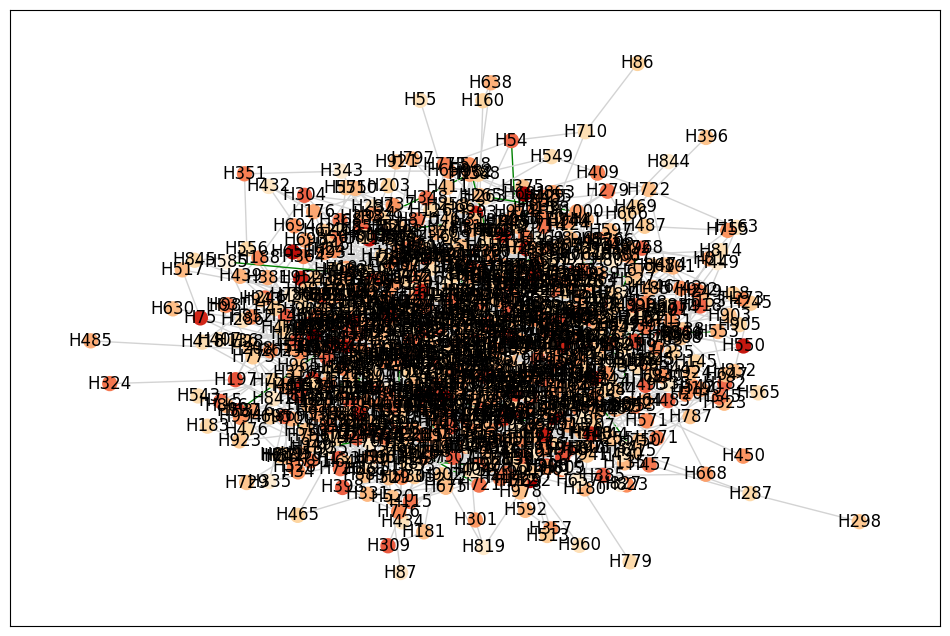

In [64]:
plt.figure(figsize=(12,8))
node_color = [G.nodes[n]['need_score'] for n in G.nodes()]
edge_colors = ['green' if ((alloc_df['from']==u)&(alloc_df['to']==v)).any() else 'lightgrey' for u,v in G.edges()]

nx.draw_networkx(
    G,
    node_color=node_color,
    cmap=plt.cm.OrRd,
    with_labels=True,
    edge_color=edge_colors,
    node_size=100
)
# plt.savefig("../outputs/visualizations/allocation_graph.png", dpi=200)
plt.show()


In [63]:
alloc_df.to_csv("../outputs/allocations/allocations_demo.csv" , index = False)

In [46]:
fairness_summary = {
    "total_households": G.number_of_nodes(),
    "affected_households": len(affected_nodes),
    "covered_households": len(received_nodes),
    "coverage_ratio": fairness_ratio
}

In [47]:
pd.DataFrame([fairness_summary]).to_csv(
    "../outputs/reports/fairness_summary.csv",
    index=False
)